In [162]:
import numpy as np 
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex
import linearcorex

from sklearn.datasets import make_spd_matrix
import sklearn.covariance as skcov

import random
from scipy.stats import multivariate_normal

# Generate Data

### custom procedure, where $|\rho(x_i, z_{parent})| \ge 0.8$ and $Var[z_i] = 1$

In [164]:
def generate_data_custom(nv, m, nt, ns):

    def get_stds(m):
        return np.ones((m,))

    def get_correlations(nv):
        return np.sign(np.random.normal(size=(nv, ))) * np.random.uniform(0.8, 0.99, size=(nv,))

    def generate_single(stds, cor):
        nv = len(cor)
        m = len(stds)
        z = [np.random.normal(0.0, v) for v in stds]
        x = np.zeros((nv,))
        snr = []
        for i in range(nv):
            par = i // (nv // m)
            mean = cor[i] / stds[par] * z[par]
            var = 1 - cor[i] ** 2
            snr += [stds[par]**2 / var]
            x[i] = np.random.normal(mean, np.sqrt(var))
        print "Average SNR: {}".format(np.mean(snr))
        return x
    
    stds = get_stds(m)
    cors = get_correlations(nv)
    return [np.array([generate_single(stds, cors) for i in range(ns)])
                for t in range(nt)]

### with fixed SNR

In [166]:
def generate_data_fixed_SNR(nv, m, nt, ns, SNR=5.0):

    def get_stds(m):
        return np.ones((m,))

    def generate_single(stds):
        nv = len(cor)
        m = len(stds)
        z = [np.random.normal(0.0, v) for v in stds]
        x = np.zeros((nv,))
        for i in range(nv):
            par = i // (nv // m)
            var = (stds[par]**2) / SNR
            x[i] = z[par] + np.random.normal(0, np.sqrt(var))
        return x

    stds = get_stds(m)
    return [np.array([generate_single(stds) for i in range(ns)])
                for t in range(nt)]

### construct NGLF data by $I + vv^T$, where $v$ is a random vector.

In [168]:
def generate_data_cov_matrix(nv, m, nt, ns):
    assert nv % m == 0
    
    covs = []
    for i in range(m):    
        random_vector = np.random.uniform(-8, 8, size=(nv // m ,))
        cov_nglf = np.eye(nv // m) + np.outer(random_vector, random_vector)
        # normalization
        stds = np.sqrt(cov_nglf.diagonal()).reshape((nv // m, 1))
        cov_nglf /= stds
        cov_nglf /= stds.T
        covs += [cov_nglf]

    def generate_single(covs):
        ret = []
        for cov in covs:
            myu = np.zeros((nv // m,))
            ret += [np.random.multivariate_normal(myu, cov)]
        return np.concatenate(ret, axis=0)

    return [np.array([generate_single(covs) for i in range(ns)])
                for t in range(nt)]

In [170]:
nt = 10
m = 8
nv = 512

data = []
data += generate_data_cov_matrix(nv, m, nt, 8 + 100)
X = [x[:8] for x in data]
Y = [x[8:] for x in data]

## normalize data

In [173]:
for t in range(nt):
    stds = np.std(Y[t], axis=0)
    X[t] /= stds
    Y[t] /= stds

### sample covariance 

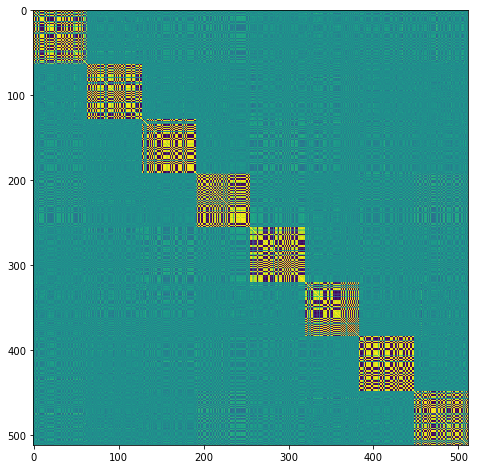

In [176]:
plt.figure(figsize=(8, 8))
plt.imshow(np.cov(Y[0].T))
plt.show()

# Learn independent linear corexes on each timestep

In [178]:
cs = []
for x in X:
    c = linearcorex.Corex(n_hidden=m,
                    max_iter=500,
                    anneal=True)
    c.fit(x)
    cs.append(c)
    
print sum([c.tc for c in cs])

7356.58938026


In [180]:
cs_covs = [c.get_covariance() for c in cs]

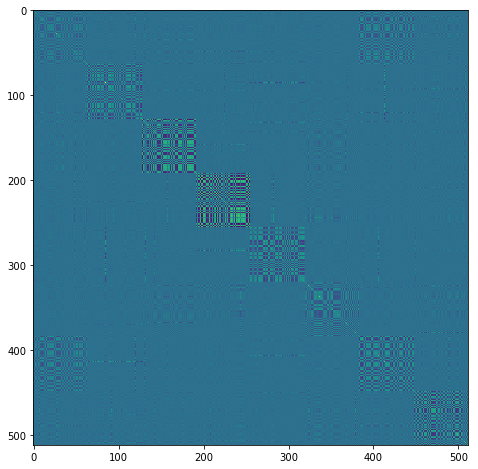

In [182]:
plt.figure(figsize=(8,8))
plt.imshow(cs_covs[0])
plt.show()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. We would like to see a peak at the middle timestep, but as we don't have many training samples there is no clear peak. We can say that the model overfits a lot at each timestep.

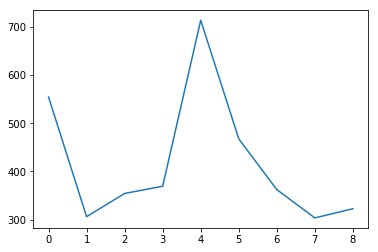

NLL = 417.154824844


In [184]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=cs_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [186]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=cs_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 417.136114687


# no regularization

In [25]:
c0 = theano_time_corex.TimeCorexSigma(nt=nt,
                                    nv=nv,
                                    n_hidden=m,
                                    max_iter=500,
                                    verbose=False,
                                    anneal=True)
c0.fit(X)
print sum(c0.tc)

Annealing iteration finished, time = 52.9321591854
Annealing iteration finished, time = 52.9291210175
Annealing iteration finished, time = 52.8989129066
Annealing iteration finished, time = 52.6917910576
Annealing iteration finished, time = 52.9037950039
Annealing iteration finished, time = 52.9118058681
Annealing iteration finished, time = 52.804527998
725.658431215


In [26]:
c0_covs = c0.get_covariance()

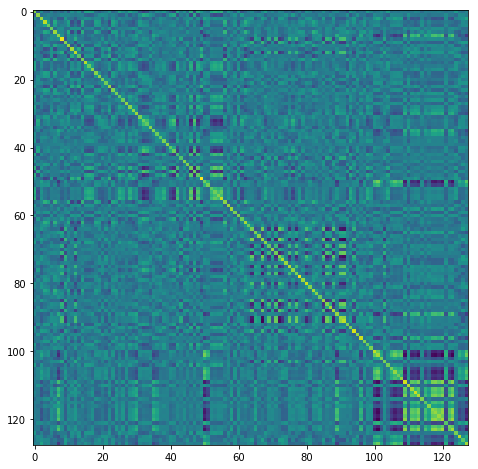

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(c0_covs[0])
plt.show()

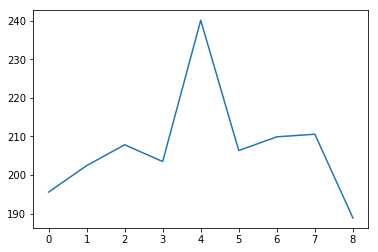

NLL = 207.226716184


In [28]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=c0_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

In [29]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=c0_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 202.873305862


### some drafts

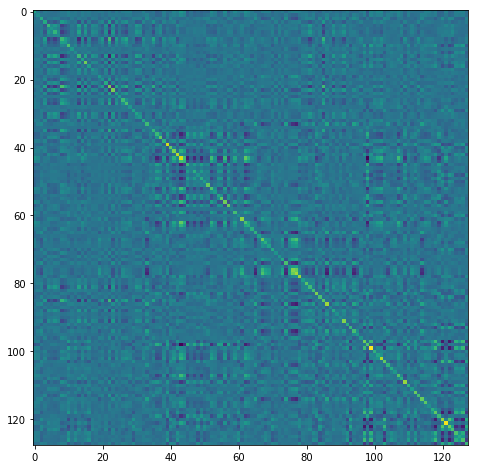

In [16]:
SN = c0.get_norm_covariance(*c0.x_std)
S = [s * c0.theta[t][1].reshape((1, nv)) * c0.theta[t][1].reshape((nv, 1)) for t, s in zip(range(nt), SN)]
plt.figure(figsize=(8,8))
plt.imshow(S[0])
plt.show()

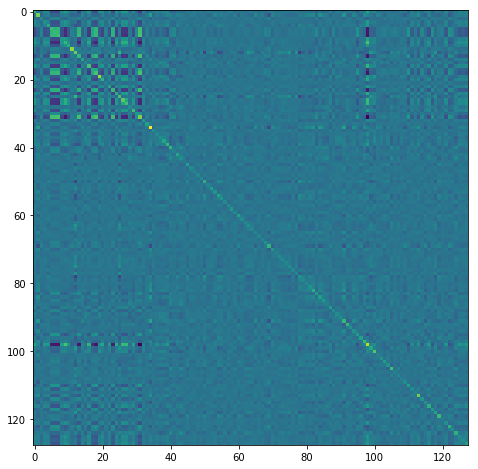

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(S[1])
plt.show()

In [18]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=S[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 264.255410408


# L1 regularization on the difference of neighbouring covariance estimates

In [74]:
csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                        nv=nv,
                                        n_hidden=m,
                                        max_iter=400,
                                        verbose=False,
                                        anneal=True,
                                        l1=0.01)
csig.fit(X)
print sum(csig.tc)

Annealing iteration finished, time = 15.9573960304
Annealing iteration finished, time = 12.9606108665
Annealing iteration finished, time = 12.8338589668
Annealing iteration finished, time = 12.7334039211
Annealing iteration finished, time = 12.6774988174
Annealing iteration finished, time = 12.6042098999
Annealing iteration finished, time = 12.6071498394
5984.62357374


In [75]:
csig_covs = csig.get_covariance()

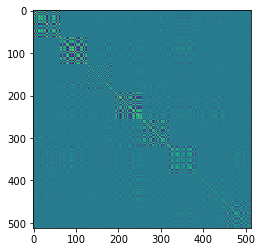

In [76]:
plt.imshow(csig_covs[0])
plt.show()

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. As we regularize the model we have less overfitting and the system is able to find the change at the middle.

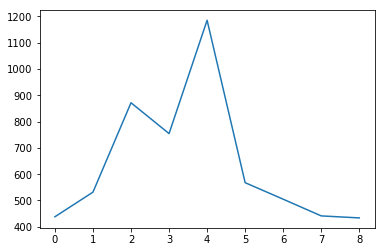

NLL = 636.405270591


In [77]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [78]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=csig_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 557.65478718


# Other methods of covariance estimation

# Diagonal matrix

In [187]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

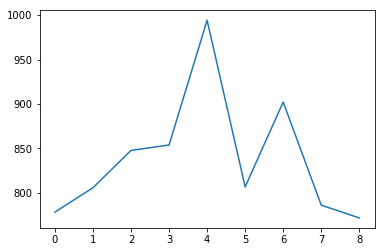

NLL = 838.567489459


In [188]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [189]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=diag_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 836.586828458


## Ledoit-Wolf Estimation

In [190]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

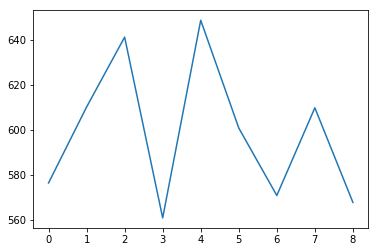

NLL = 598.483408689


In [191]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [192]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=lw_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 592.228346871


## Oracle Approximating Shrinkage

In [193]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

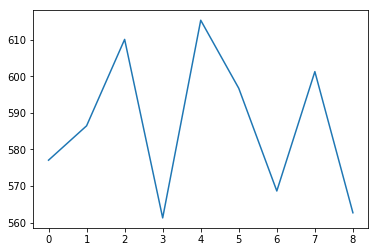

NLL = 586.613883058


In [194]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [195]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=oas_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

NLL = 580.920363914


## Graphical LASSO

In [196]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso(mode='lars')
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

OverflowError: long int too large to convert to float

#### This graph shows how well the covariance ESTIMATE of timestep t models the test data at timestep t+1. 

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t]) for sx in x]) for x,t in zip(Y[1:], range(nt-1))]
plt.plot(nll)
plt.show()
print "NLL = {}".format(np.mean(nll))

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [ ]:
nll = [-np.mean([multivariate_normal.logpdf(sx, cov=glasso_covs[t]) for sx in x]) for x,t in zip(Y, range(nt))]
print "NLL = {}".format(np.mean(nll))

# Summary of the results


| Model | NLL |  
|:------|----:|  
| ground truth                     | ????????? |  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |
